# Защита персональных данных клиентов

In [2]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
def get_random_matrix(rows, cols):
    matrix = np.random.normal(size=(rows, cols))
    try:
        inv_matrix = np.linalg.inv(matrix)
        return matrix, inv_matrix
    except:
        get_random_matrix(rows, cols)

## Загрузка данных

In [4]:
try:
    df = pd.read_csv('/datasets/insurance.csv')
except:
    df = pd.read_csv('/Users/anshilina/Documents/insurance.csv')

In [5]:
display(df)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [6]:
display(df.describe())

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
df['Возраст'] = df['Возраст'].astype('int')

In [9]:
print('Количество пропусков в массиве:', df.isna().sum().sum())

Количество пропусков в массиве: 0


In [10]:
print('Количество дубликатов в массиве:', df.duplicated().sum())

Количество дубликатов в массиве: 153


In [11]:
df.drop_duplicates(inplace=True)

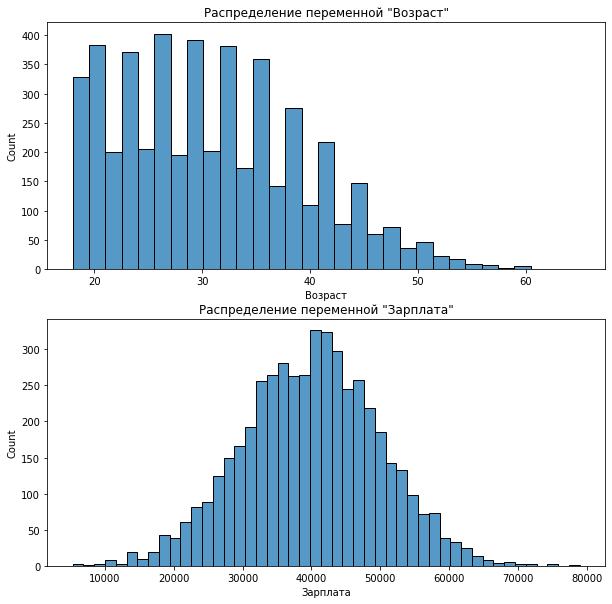

In [12]:
col_names = ['Возраст', 'Зарплата']
_, axs = plt.subplots(2, 1, figsize=(10,10))
axs = axs.ravel()

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[col_names[i]], data=df)
    ax.tick_params(axis='x')
    ax.set_title(f'Распределение переменной "{col_names[i]}"')

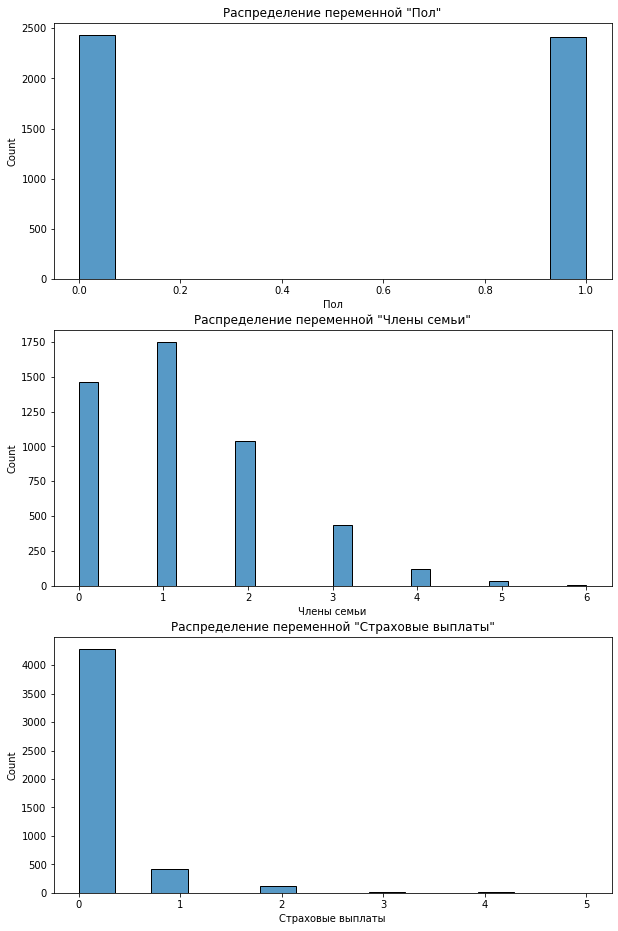

In [13]:
col_names = ['Пол', 'Члены семьи', 'Страховые выплаты']
_, axs = plt.subplots(3, 1, figsize=(10,16))
axs = axs.ravel()

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[col_names[i]], data=df)
    ax.tick_params(axis='x')
    ax.set_title(f'Распределение переменной "{col_names[i]}"')

**Вывод:** Всего в массиве 5 тыс. наблюдений, 153 из которых являются дубликатами – удаляем их из выборки. В данных нет пропущенных значений. Изучив переменные, мы пришли к выводу, что значения переменной `возраст` можно поменять на целочисленные – обычно в исследованиях используют данные в точности до года. Переменная `пол` бинарная – в массиве одинаковое количество мужчин и женщин. Переменные `члены семьи` и `страховые выплаты` дискретные. Больше всего в выборке тех, у кого 1 член семьи, меньше всего – больших семей из 5-6 человек. Чаще всего люди из выборки не получали никаких страховых выплат, что может быть связано с отсутствием страховых случаев. 

In [14]:
display(df.corr())

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.001953,0.015456,-0.007315,0.011565
Возраст,0.001953,1.000000,-0.017386,-0.009064,0.654964
Зарплата,0.015456,-0.017386,1.000000,-0.031687,-0.013123
Члены семьи,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
Страховые выплаты,0.011565,0.654964,-0.013123,-0.039303,1.000000


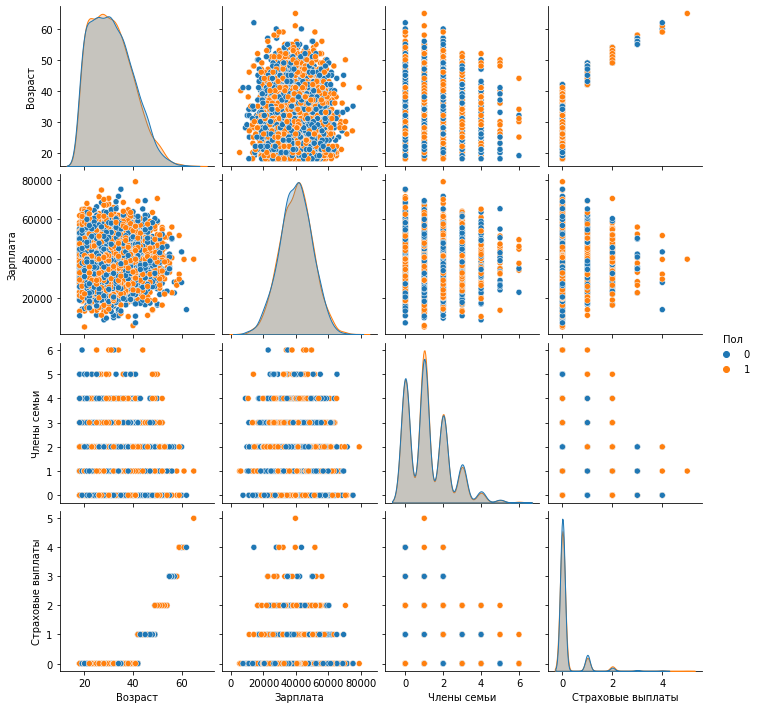

In [15]:
sns.pairplot(df, hue='Пол')
plt.show()

**Вывод:** В данных признаки друг с другом слабо скореллированы, т.е. проблему мультиколлинеарности мы не наблюдаем. Мультиколлинеарность искажает результаты линейных моделей, не так сильно вредит дереву решений и случайному лесу. Из-за сильной скореллированности признаков линейные модели могут переобучаться. Кроме того, мультиколлинеарность означает, что в модели есть избыточные переменные, которые не привносят пользы при обучении, а только увеличивают время обучения модели и затрудняют последующую интерпретацию результатов.

Одним из признаком мультиколлинеарности является то, что изменения в выборке приводят к значительным изменениям оценок параметров модели. Наша цель как разтаки внести изменения в выборку (зашифровать данные), но при этом избежать ухудшения качества модели. Высокая мультиколлинеарность могла бы исказить наблюдаемый результат.

## Умножение матриц

**Ответ:** Если умножить признаки на обратимую матрицу, качество линейной регрессии не должно сильно поменяться. 

**Обоснование:** Это связано с тем, что сама линейная регрессия безразлична к изменению масштаба признаков. Поэтому если мы домножим матрицу признаков на обратимую квадратную матрицу со случайными значениями из, например, нормального распределения, признаки относительно друг друга не поменяются – их вес относительно друг друга останется прежним, следовательно, на подбор коэффициентов линейной регрессии эта манипуляция с данными не повлияет. В то же время, если нам понадобится декодировать данные, мы можем домножить получившуюся в ходе перемножения матрицу на обратную ей. По той же причине мы можем спокойно использовать скалирование признаков (StandardScaler и проч.), чтобы привести признаки к одной шкале и сравнивать их между собой, не боясь, что это как-то скажется на результатах обучения нашей модели.

Таким образом, задача линейной регрессия на закодированных данных будет решаться следующим образом:

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $R$ — матрица случайных значений, на которую умножаются признаки

- $y$ — вектор целевого признака

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a1 = Xw1
$$

$$
a2 = XRw2
$$

Задача обучения:

$$
w1 = \arg\min_w MSE(Xw, y)
$$

$$
w2 = \arg\min_w MSE(XRw, y)
$$

Формула обучения:

$$
w1 = (X^T X)^{-1} X^T y
$$

$$
w2 = ((XR)^T (XR))^{-1} (XR)^T y
$$


Свойства матриц:

$$ 
A * B * C = A * (B * C) 
$$ 

$$ 
(A * B)^T = B^T * A^T 
$$ 

$$
(A * B)^{-1} = B^{-1} * A^{-1}
$$ 

$$ 
A * A^{-1} = E
$$ 

Используя эти свойства найдём предсказания на закодированной матрице и сравним с предсказаниями на обычной матрице:

$$
w2 = ((XR)^T (XR))^{-1} (XR)^T y = (R^T (X^T X) R)^{-1} R^T X^T y = R^{-1} (X^T X)^{-1} (R^T)^{-1} R^T X^T y = R^{-1} (X^T X)^{-1} X^T = R^{-1} w1
$$

$$
a2 = X R R^{-1} w1 = X w1
$$

## Алгоритм преобразования

**Алгоритм:**

* Создадим квадратную матрицу из случайных значений. Размер матрицы соотверствует количеству признаков.
* Проверим матрицу на обратимость. Если она не обратимая, продолжим генерировать матрицы до тех пор, пока не получим обратимую.
* Закодируем данные: домножим матрицу признаков на матрицу случайных значений, сохраним получившееся признаковое пространство в отдельную переменную.
* Обучим модель линейной регрессии на новый данных, посчитаем R2 метрику на тестовых данных.
* Обучим модель линейной регрессии на изначальном массиве данных, посчитаем R2 метрику на тестовых данных.
* Сравним метрики, полученные по результатам обучения двух моделей – ожидаем, что они совпадут.

## Проверка алгоритма

In [16]:
# получим признаки и целевую переменную 

features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

In [17]:
random_matrix, inv_matrix = get_random_matrix(features.shape[1], features.shape[1])

In [18]:
# получим закодированные признаки 

features_safe = features @ random_matrix
display(features_safe.head())

,0,1,2,3
0,-19782.450123,1944.510974,-8642.924558,-51632.339477
1,-15152.915080,1467.911015,-6595.213335,-39570.648581
2,-8373.080094,805.098430,-3637.459950,-21870.650755
3,-16635.278786,1656.476380,-7291.678616,-43398.208053
4,-10407.938927,1012.928007,-4535.990381,-27174.399227


In [19]:
# разделим выборку на тренировочную и тестовую 
features_train, features_test, target_train, target_test = \
                                        train_test_split(features, target, test_size=0.25, random_state=42)

# тот же алгоритм для закодированных данных
features_safe_train, features_safe_test, target_safe_train, target_safe_test = \
                                        train_test_split(features_safe, target, test_size=0.25, random_state=42)

In [20]:
# создадим пайплайн
pipe = Pipeline([('scaler', StandardScaler()), ('lin_model', LinearRegression())])

In [21]:
# посмотрим на качество модели на защищенных данных

pipe.fit(features_safe_train, target_safe_train)
print(r2_score(target_safe_test, pipe.predict(features_safe_test)))

0.44346330831608183


In [22]:
# посмотрим на качество модели на незащищенных данных

pipe.fit(features_train, target_train)
print(r2_score(target_test, pipe.predict(features_test)))

0.44346330831611935


**Вывод:** Мы убедились, что наш алгоритм работает: модель одинаково справляется с предсказаниями на закодированных и на не закодированных данных. Метрики качества R2 практически идентичные, отличие наблюдается только в 13-ом знаке, что может быть связанно с тем, что у некоторых признаков вещественный тип – числа с плавающей точкой.

В результате мы создали класс `EncoderMatrix`, который можно использовать для шифрования данных в дальнейшем.

In [23]:
class EncoderMatrix(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        size = len(variables)
        
        def get_matrix(rows, cols):    
            matrix = np.random.normal(size=(rows, cols))
            try:
                inv_matrix = np.linalg.inv(matrix)
                return matrix
            except:
                get_matrix(rows, cols)
        
        self.matrix = get_matrix(size, size)
    
    def fit(self, feature, target):
        return self
    
    def transform(self, features):
        features_transformed = features.drop(self.variables, axis=1)
        features_transformed[self.variables] = features[self.variables] @ self.matrix
        return features_transformed

Включим все этапы предобработки в `Pipeline`.

In [24]:
pipe_final = Pipeline([('encoder', EncoderMatrix(features.columns)), 
                       ('scaler', StandardScaler()), 
                       ('lin_model', LinearRegression())])

In [25]:
pipe_final.fit(features_train, target_train)

Pipeline(steps=[('encoder',
                 EncoderMatrix(variables=Index(['Пол', 'Возраст', 'Зарплата', 'Члены семьи'], dtype='object'))),
                ('scaler', StandardScaler()),
                ('lin_model', LinearRegression())])

In [26]:
print(r2_score(target_test, pipe_final.predict(features_test)))

0.4434633083161039


## Вывод

В проекте использовались данные клиентов страховой компании. В ходе исследования данных не были обнаружены пропуски в них, но были выявлены и удалены дубликаты, также был изменен тип некоторых переменных и проведена проверка на мультиколлинеарность. В качестве целевой переменной рассматривалось количество страховых выплат, признаками объектов стали пол, возраст и зарплата застрахованного, количество членов его семьи. 

Далее была проведена теоретическая проверка предположения о том, что умножение признаков на обратимую матрицу с целью зашифровать данные не повлияет на результаты линейной регрессии. В ходе математических преобразований данное предположение подтвердилось, в результате чего был разработан алгоритм проверки этого предположения на реальных данных. Алгоритм включает в себя:

* Подбор квадратной матрицы из случайных значений, включающий проверку матрицы на обратимость 
* Шифровку данных путем домножения матрицы признаков на матрицу случайных значений
* Обучение моделей на изначальных и преобразованных данных, сравнение метрик R2, полученных по результатам обучения двух моделей

Далее были представлены результаты реализации этого алгоритма. Наши предположения подтвердились: метрика качества по итогам обучения модёли на зашифрованных данных практически не отличается от метрики качества, полученной в результате обучения линейной регрессии на исходных данных (отличие в 13-ом знаке рассматривалось как несущественное и связанное с наличием в данных вещественных чисел).